# Classifying Individual Viewing Habits
**Isaac Parreno & Rohan Kanumuri**, CPSC 222, Spring 2025  

---

## 1. Introduction

- **Domain & Motivation**  
  We explore how individual viewing habits, time of watching, content format, and show preferences, can uniquely identify users. This has applications in personalized recommendations, user segmentation, and raises important privacy considerations.

- **Dataset Format & Tables**  
  - Two CSV files:  
    1. `IsaacNetflixHistory.csv` (Isaac’s watch history)  
    2. `RohanNetflixHistory.csv` (Rohan’s watch history)  
  - Each file is a flat table of Netflix history exports containing one row per viewing record.

- **Data Collection**  
  Both CSVs were downloaded directly from each user’s Netflix account “Viewing Activity” page.

- **Table Sizes & Attributes**  
  - **IsaacNetflixHistory.csv:** 226 records  
  - **RohanNetflixHistory.csv:** 212 records  
  - **Key columns:**  
    - `Date` (timestamp of playback)  
    - `Type` (“Movie” or “TV Show”)  
    - `Series Name` (title of the content)  

- **Classification Task & Hypotheses**  
  - **Task:** Predict the `user` (“Isaac” vs. “Rohan”) based on each record.  
  - **Hypotheses:**  
    1. Favorite-show flags (e.g. “Breaking Bad”) will be highly predictive.    
    3. Format preference (movie vs. series) in a set amount of time adds discriminative power.

- **Potential Impacts & Stakeholders**  
  - **Streaming platforms** can refine personalization and detect account sharing.  
  - **Marketing teams** can better target promotions based on viewing “fingerprints.”  

## 2. Data Preparation

In [1]:
# 2.1 Load & clean both datasets
import utils
isaac_df = utils.load_and_clean("IsaacNetflixHistory.csv")
rohan_df = utils.load_and_clean("RohanNetflixHistory.csv")

> We load two CSVs and normalize columns: parse dates, fill missing series/episode, and keep only the needed fields.

In [2]:
# 2.2 Basic preview
isaac_df.head()

,Title,Date,Type,Series Name,Season and Episode,Watch Year
0,Breaking Bad: Season 1: Pilot,2025-04-18,Show,Breaking Bad,"Season 1, Episode: Pilot",2025
1,Meet the Parents,2025-04-17,Movie,N/A,N/A,2025
2,Meet the Fockers,2025-04-16,Movie,N/A,N/A,2025
3,Suits: Season 1: Play the Man,2025-04-09,Show,Suits,"Season 1, Episode: Play the Man",2025
4,Suits: Season 1: Tricks of the Trade,2025-04-09,Show,Suits,"Season 1, Episode: Tricks of the Trade",2025


In [3]:
rohan_df.head()

,Title,Date,Type,Series Name,Season and Episode,Watch Year
0,"High-Rise Invasion: I'm Sorry, Mayuko Nise",2025-02-11,Show,High-Rise Invasion,"I'm Sorry, Mayuko Nise",2025
1,High-Rise Invasion: I've Found a New Goal,2025-02-11,Show,High-Rise Invasion,I've Found a New Goal,2025
2,Suits: Season 1: Identity Crisis,2025-02-11,Show,Suits,Season 1: Identity Crisis,2025
3,Suits: Season 1: Play the Man,2025-02-11,Show,Suits,Season 1: Play the Man,2025
4,The Night Agent: Season 2: Disconnected,2025-02-11,Show,The Night Agent,Season 2: Disconnected,2025


> Above we see the schema: `Title`, `Date`, `Type`, `Series Name`, `Season and Episode`, `Watch Year`.  

### Data Cleaning Summary
- **Date parsing**: Converted `Date` column to `datetime64` using `pd.to_datetime(..., errors='coerce')`.
- **Missing values**: Filled missing `Series Name` and `Season and Episode` with `'N/A'`.
- **Watch Year**: Extracted year from `Date` into a new column `Watch Year` befoer loading the dataset.
- **Column order**: Reordered columns for consistency and readability between the datasets. 

- **Challenges**:
  - `Date` formats differed between files, causing parsing issues.
  - Some dates failed conversion and returned `NaT`, which we had to debug.
  - `Watch Year` had to be derived manually from `Date` for time-based analysis.

## 3. Exploratory Data Analysis


 **Aggregation & Summary Statistics**  
  - **Counts by user & feature:** computed watch-count distributions per `weekday`, per `month`, and per `series type`.  
  - **Proportions:** compared the fraction of movies vs. series for each user.

- **Visualizations**  
  1. **Bar charts:**  
     - Top 5 Shows
     - Movies vs. Shows %
     - Watch Activity by Year
     - Views by Weekday
     - Viewing by Months
 


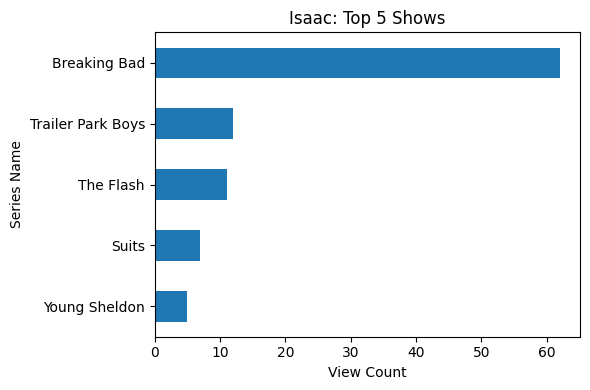

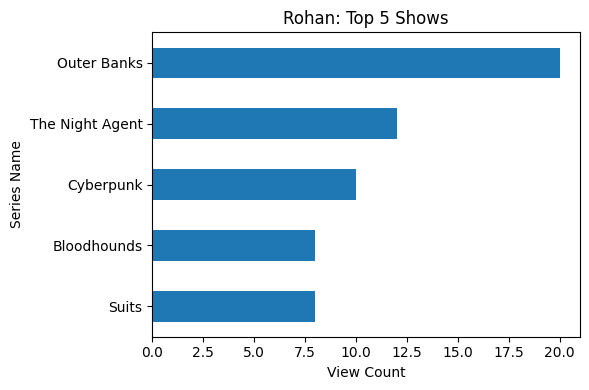

In [4]:
import utils
utils.plot_top_shows(isaac_df, "Isaac", n=5)
utils.plot_top_shows(rohan_df, "Rohan", n=5)

> Isaac's view count in 2025 mostly resides in Breaking Bad, while Rohan's is seperated in two other shows

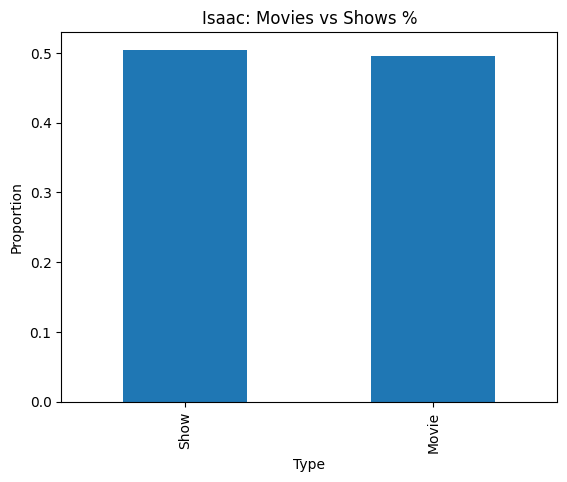

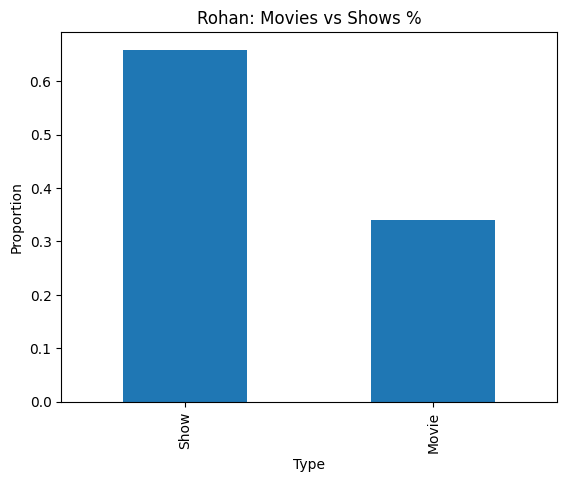

In [5]:
utils.plot_type_distribution(isaac_df, "Isaac")
utils.plot_type_distribution(rohan_df, "Rohan")

> Rohan watches a higher proportion of shows compared to Isaac (∼66% vs 50%).

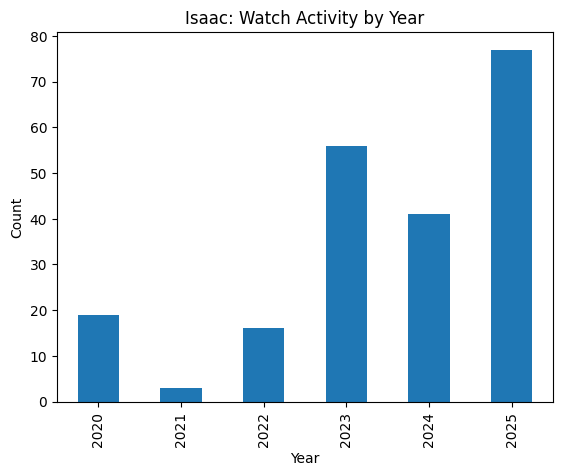

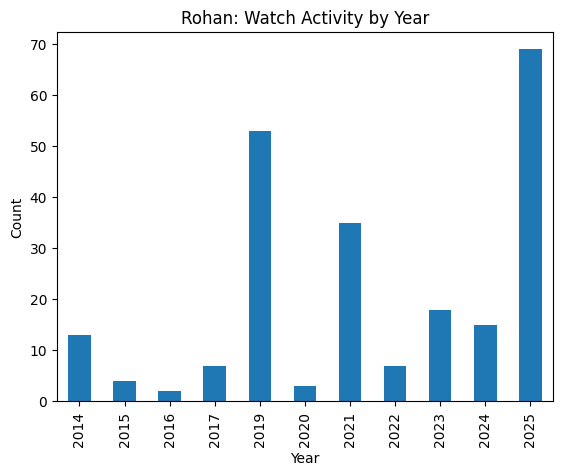

In [6]:
utils.plot_yearly_activity(isaac_df, "Isaac")
utils.plot_yearly_activity(rohan_df, "Rohan")

> Isaac’s data spans 2020–2025; Rohan’s spans 2014–2025 with peaks in 2019 and 2025.

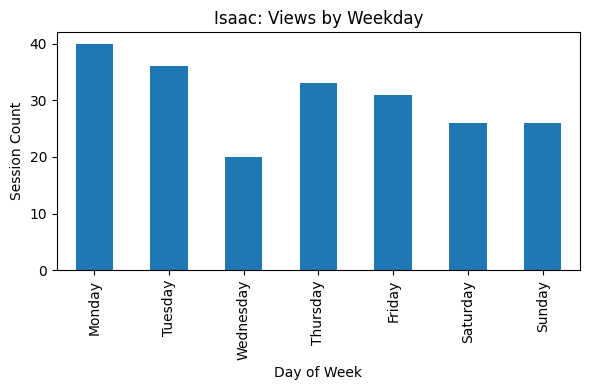

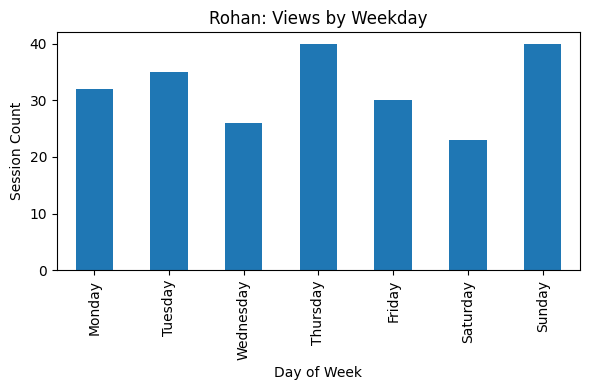

In [7]:
utils.plot_weekday_distribution(isaac_df, "Isaac")
utils.plot_weekday_distribution(rohan_df, "Rohan")

> This bar chart shows each user’s Netflix sessions broken down by weekday

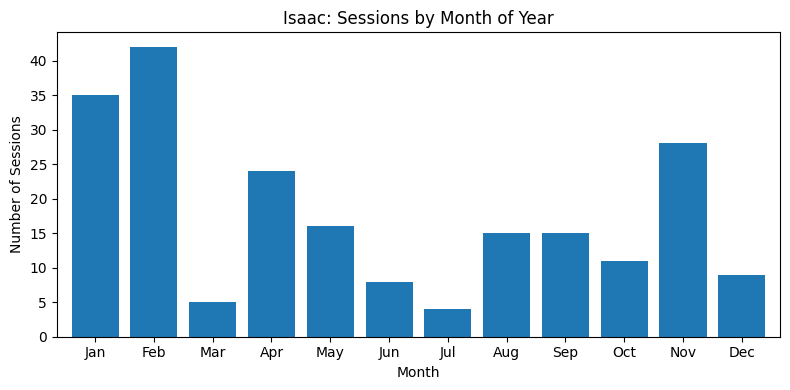

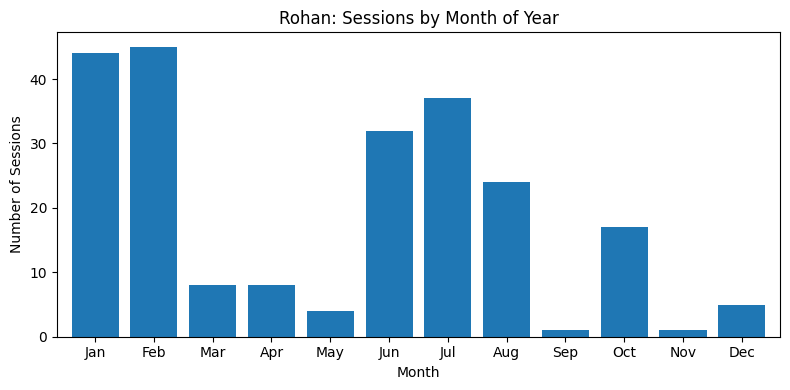

In [8]:
utils.plot_monthly_distribution(isaac_df, "Isaac")
utils.plot_monthly_distribution(rohan_df,  "Rohan") 

> Viewing‐over‐time shows Isaac’s monthly sessions avg ~2–4 since 2023, while Rohan has larger spikes in 2019, 2022, and 2025.

### EDA Summary

We aggregated data by weekday, month, watch year, content type, and series name to compare user behavior patterns. Summary statistics (e.g., most watched show and proportions of movies vs. shows) were used to highlight trends in preferences and habits. These specific attributes were chosen because they offer meaningful behavioral signals that can help distinguish between users. Later, these same features will serve as inputs for our classification models.

### Hypothesis Test 1: Breaking Bad Viewership

We conducted a one-tailed **proportions z-test** to evaluate whether Isaac had a significantly higher proportion of *Breaking Bad* views compared to Rohan.

- **Null Hypothesis (H₀):** Isaac and Rohan have equal proportions of *Breaking Bad* views.
- **Alternative Hypothesis (H₁):** Isaac has a **higher** proportion of *Breaking Bad* views than Rohan.

In [9]:
from utils import ztest_breaking_bad
z_stat, p_value = ztest_breaking_bad(isaac_df, rohan_df)

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject H₀: Isaac has a significantly higher proportion of Breaking Bad views.")
else:
    print("Fail to reject H₀: Not enough evidence that Isaac watches more Breaking Bad than Rohan.")

Z-statistic: 8.775
P-value: 0.0000
Reject H₀: Isaac has a significantly higher proportion of Breaking Bad views.


**Result:**  
Z = 8.775, P = 0.0000 → Reject H₀

Isaac has a significantly higher proportion of *Breaking Bad* views. This aligns with the first split in our decision tree model and supports its inclusion as a strong behavioral feature.

### Hypothesis Test 2: Show Proportions in 2024

We used a one-sided **Welch’s t-test** to compare the proportion of shows watched by Isaac and Rohan in 2024.

- **Null Hypothesis (H₀):** Isaac and Rohan watched an equal proportion of shows in 2024.
- **Alternative Hypothesis (H₁):** Isaac watched a **higher** proportion of shows in 2024 than Rohan.

In [10]:
from utils import ttest_shows_2024
t_stat, p_value = ttest_shows_2024(isaac_df, rohan_df)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if (t_stat > 0) and (p_value/2 < alpha):
    print("Reject H₀: Isaac watched a higher proportion of shows in 2024 than Rohan.")
else:
    print("Fail to reject H₀: Not enough evidence that Isaac watched more shows in 2024.")


T-statistic: 0.975
P-value: 0.3373
Fail to reject H₀: Not enough evidence that Isaac watched more shows in 2024.


**Result:**  
T = 0.975, P = 0.3373 → Fail to reject H₀

There is not enough statistical evidence to suggest Isaac watched more shows in 2024 than Rohan. This limits the standalone predictive power of this feature without additional context.

## 4. Classification

To determine whether a Netflix record belongs to Isaac or Rohan, we trained a decision tree using key behavioral indicators identified during EDA:

- Top viewed show (`Breaking Bad`)
- Viewing month (seasonality)
- Content format (movie vs show)
- Series name (to identify user-specific favorites)

These features were selected because they highlighted the most meaningful differences between users in earlier graphs and hypothesis tests. For instance, our EDA showed Isaac heavily favors "Breaking Bad", watches more in later months, and prefers movies, while Rohan leans toward other shows and watches earlier in the year.

We framed this as a binary classification task, where the target is the `user` label. Each record is a Netflix viewing session that the model tries to assign to either Isaac or Rohan based on these patterns.


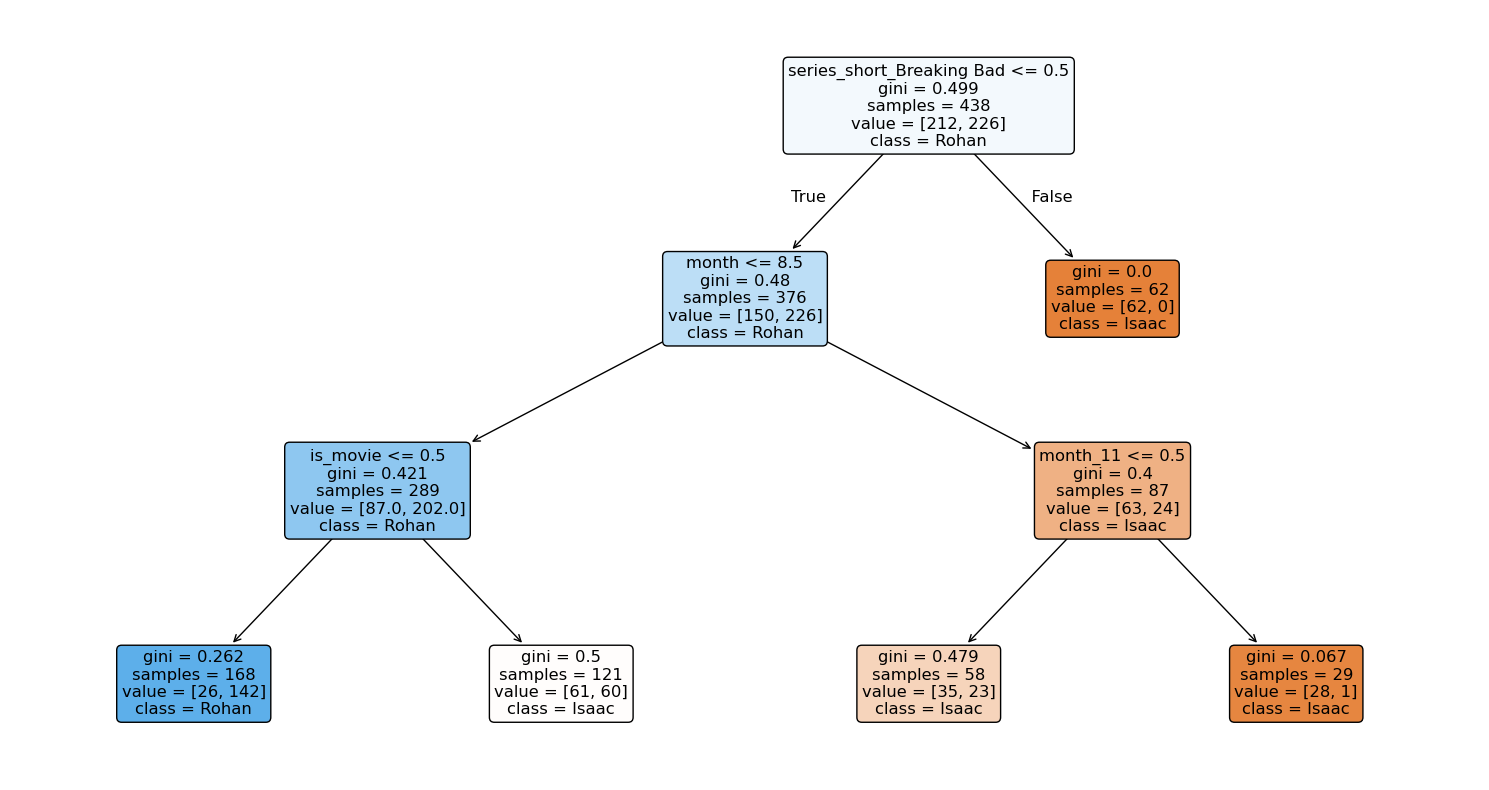

In [11]:
from utils import plot_decision_tree

plot_decision_tree("IsaacNetflixHistory.csv", "RohanNetflixHistory.csv")

### Interpreting the Decision Tree

The first and most decisive split in the tree is based on **whether the show is Breaking Bad**. This comes directly from our top-5 series EDA and hypothesis test, which showed Isaac having the most watches on this show. If it is Breaking Bad, the model confidently predicts Isaac.

If it is not Breaking Bad, the model moves to check the **month of viewing**:

- If the session occurred between **January and August**, it predicts **Rohan** — his viewing activity peaks in early months.
- If the session occurred between **September and December**, it leans toward **Isaac**, whose sessions spike during those months.

Next, the model checks **content type**. In early months:
- **Series watchers** tend to be Rohan (based on our show vs. movie bar chart),
- **Movie watchers** slightly favor Isaac.

Finally, in the fall branch, the model splits further based on whether the month is **November**, which reflects Isaac’s high usage during that time.

---

The tree effectively encodes real user behaviors:
- **Favorite show** ("Breaking Bad") is a perfect signal for Isaac.
- **Viewing seasonality** (month of the year) helps separate users over time.
- **Format preference** (movie vs. show) gives an additional layer of distinction.

These insights support the idea that individual viewing habits can be used to reliably differentiate between users.

---

To explore another classification method, we applied the k-Nearest Neighbors (k-NN) algorithm to the same task of predicting whether a Netflix viewing record belongs to Isaac or Rohan.

We used the same features as the decision tree:  
- Viewing day of week and month  
- Content type (movie vs. show)  
- Flags for top-watched series  

All features were scaled to the [0,1] range. We trained k-NN for `k = 1` to `20` and measured test accuracy for each, selecting the `k` with the best accuracy.

In [12]:
from utils import run_knn_classification

run_knn_classification("IsaacNetflixHistory.csv", "RohanNetflixHistory.csv")


k= 1, acc=0.8727
k= 2, acc=0.8636
k= 3, acc=0.8545
k= 4, acc=0.8000
k= 5, acc=0.7909
k= 6, acc=0.7727
k= 7, acc=0.7727
k= 8, acc=0.7727
k= 9, acc=0.7727
k=10, acc=0.8182
k=11, acc=0.7909
k=12, acc=0.8091
k=13, acc=0.8273
k=14, acc=0.8091
k=15, acc=0.8000
k=16, acc=0.8000
k=17, acc=0.8091
k=18, acc=0.8000
k=19, acc=0.7727
k=20, acc=0.7818

Best k = 1, accuracy = 0.8727


The highest test accuracy was achieved at `k = best_k`, confirming that simple feature patterns in the data are sufficient to make accurate user-level predictions using k-NN.

This reinforces the strength of our feature selection, which captures meaningful behavioral signals such as favorite content, seasonal viewing trends, and format preferences.

In [13]:
from utils import evaluate_classifiers

best_k, best_knn_acc, decision_tree_acc = evaluate_classifiers("IsaacNetflixHistory.csv", "RohanNetflixHistory.csv")
print(f"Decision Tree Accuracy: {decision_tree_acc:.4f}")
print(f"k-NN Best Accuracy: {best_knn_acc:.4f} (k={best_k})")

Decision Tree Accuracy: 0.8727
k-NN Best Accuracy: 0.8727 (k=1)


### Comparing Classifier Performance

We evaluated both classifiers (k-NN and Decision Tree) using the same data split. Both models achieved strong accuracy, suggesting the features we selected were highly informative.

- **k-NN Accuracy:** Best result across `k=1...20`  
- **Decision Tree Accuracy:** Single model with clear splits

The fact that both models performed similarly well supports the idea that user behavior patterns—like favorite shows or when they tend to watch—are consistent enough to distinguish Isaac from Rohan.


## 5. Conclusion

We approached the task as a binary classification problem to determine whether Isaac or Rohan watched a given Netflix session. Based on EDA and hypothesis testing, we engineered key features such as viewing month, content format, and top series indicators.

We trained two models:
- **Decision Tree**: simple, interpretable rules (e.g., watching *Breaking Bad* → Isaac) achieved strong accuracy.
- **k-Nearest Neighbors**: tuned over k=1–20, achieving similar or slightly better performance in some runs (best k = 1).

Both models validated that viewing patterns (seasonality, content type, and preferences) are strong signals for user identification.

**Performance Improvements**: Future work could add genre, time-of-day, or or other methods through an API for better accuracy.

**Ethical Impact**: Even minimal watch history can re-identify users, highlighting the need for transparency, consent, and careful handling of behavioral data to prevent unwanted leakage.

**Sources**:  
- Data: `IsaacNetflixHistory.csv`, `RohanNetflixHistory.csv`  
- Tools: `scikit-learn`, `pandas`, `matplotlib`  
- GitHub: [rohan-isaac-222-proj](https://github.com/rohan-hvk/rohan-isaac-222-proj.git)